# Driver Engagement Analysis - EDA

In [1]:
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from rich.progress import track

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [2]:
fpath = Path.cwd().parent.joinpath('data')
files = {
    'driver_master': 'drivers_master.feather',
    'delivery_log': 'drivers_delivery_log.feather',
    'delivery_bydate': 'drivers_delivery_by_date.feather',
    'breaks_bydate': 'drivers_breaks_by_date.feather',
    'engage_report': 'drivers_engagement_clubs.feather',
    'club_report': 'driver_clubs_report_by_date.feather',
}

In [3]:
# driver delivery log
df_log = pd.read_feather(fpath.joinpath(files['delivery_log']))
df_log.head()

,driver_id,timestamp,flag,start_lon,start_lat,end_lon,end_lat,time_spent
0,bbf1910de257,2021-08-02 09:00:00,b-start,77.730816,12.803997,77.730816,12.803997,NaN
1,5e0cb788b634,2021-08-02 09:00:00,b-start,77.734455,13.067857,77.734455,13.067857,NaN
2,f9565e9303c8,2021-08-02 09:00:00,b-start,77.504914,12.944353,77.504914,12.944353,NaN
3,2993bceb3298,2021-08-02 09:00:00,b-start,77.596622,12.809530,77.663356,12.805215,NaN
4,3126568d831e,2021-08-02 09:00:00,b-start,77.734455,13.067857,77.734455,13.067857,NaN


In [4]:
# driver delivery records aggregate by date
df_delivery = pd.read_feather(fpath.joinpath(files['delivery_bydate']))
df_delivery.head()

,driver_id,date,flag,trips,time_spent,distance
0,00960ead6881,2021-08-02,delivered,0.0,0.0,0.0
1,00960ead6881,2021-08-03,delivered,0.0,0.0,0.0
2,00960ead6881,2021-08-04,delivered,0.0,0.0,0.0
3,00960ead6881,2021-08-05,delivered,0.0,0.0,0.0
4,00960ead6881,2021-08-06,delivered,0.0,0.0,0.0


In [5]:
# driver breaks records aggregate by date
df_breaks = pd.read_feather(fpath.joinpath(files['breaks_bydate']))
df_breaks.head()

,driver_id,date,flag,trips,time_spent,distance
0,00960ead6881,2021-08-02,b-end,0,600.0,0.0
1,00960ead6881,2021-08-03,b-end,0,600.0,0.0
2,00960ead6881,2021-08-04,b-end,0,600.0,0.0
3,00960ead6881,2021-08-05,b-end,0,600.0,0.0
4,00960ead6881,2021-08-06,b-end,0,600.0,0.0


In [6]:
# driver engagement cohort changes report
df_cohort = pd.read_feather(fpath.joinpath(files['engage_report']))
df_cohort.head()

,driver_id,date,flag,trips,time_spent,distance,category,change,change_flag
0,00960ead6881,2021-08-02,delivered,0.0,0.0,0.0,PD,NaN,None
1,00960ead6881,2021-08-03,delivered,0.0,0.0,0.0,PD,0.0,NoChange
2,00960ead6881,2021-08-04,delivered,0.0,0.0,0.0,PD,0.0,NoChange
3,00960ead6881,2021-08-05,delivered,0.0,0.0,0.0,PD,0.0,NoChange
4,00960ead6881,2021-08-06,delivered,0.0,0.0,0.0,PD,0.0,NoChange


In [7]:
# driver engagement cohort changes report
df_club = pd.read_feather(fpath.joinpath(files['club_report']))
df_club.head()

,date,AD,EAD,PD,UAD
0,2021-08-02,0,0,1000,0
1,2021-08-03,29,0,971,0
2,2021-08-04,99,0,901,0
3,2021-08-05,172,1,827,0
4,2021-08-06,247,2,751,0


In [8]:
# Comparison of Break time logs vs Delivery logs
df_log.flag.value_counts()

b-start      125446
b-end        125446
picked-up     39351
delivered     39351
Name: flag, dtype: int64

### What's the distribution of number of delivery trips taken on each day by all drivers over the analysis period?

In [9]:
trips = df_delivery.groupby('date').agg({'trips':'sum', 'time_spent':'sum', 'distance':'sum'})
trips.head()

,trips,time_spent,distance
date,,,
2021-08-02,469.0,2581.426,1505.74
2021-08-03,439.0,2435.588,1420.77
2021-08-04,501.0,2804.744,1636.11
2021-08-05,440.0,2501.643,1459.33
2021-08-06,445.0,2463.248,1436.92


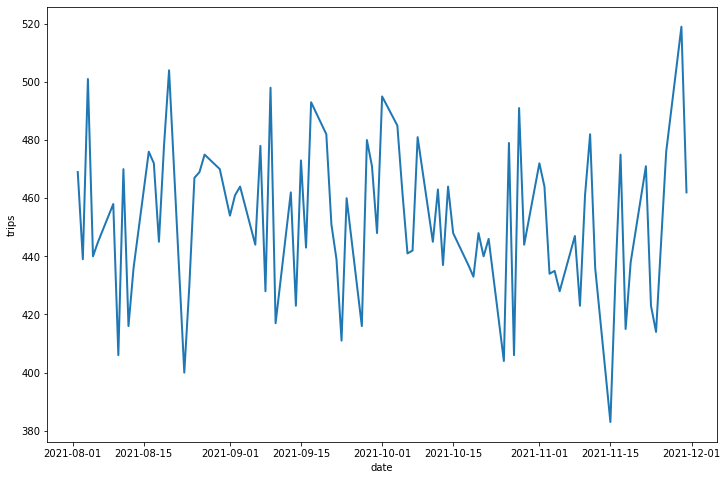

In [10]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=trips.reset_index(), x='date',
             y='trips', linewidth=2)
plt.show()

### Which month had the highest number of delivery trips made?
### Which month had the highest time spent on delivery trips?
### Which month had the lowest distance covered for deliver trips?

In [11]:
_df = df_delivery.copy()
_df['month'] = _df['date'].apply(lambda x: x.month_name())
agg = _df.groupby('month').agg({'trips':'sum', 'time_spent':'sum', 'distance':'sum'})

a_1 = agg[agg['trips'] == agg.trips.max()].index[0]
a_2 = agg[agg['time_spent'] == agg.time_spent.max()].index[0]
a_3 = agg[agg['distance'] == agg.distance.min()].index[0]
print('Month with highest number of delivery trips -', a_1)
print('Month with highest time spent on deliveries -', a_2)
print('Month with lowest distance covered for deliveries -', a_3)

Month with highest number of delivery trips - August
Month with highest time spent on deliveries - September
Month with lowest distance covered for deliveries - October


### Top 5 drivers with most deliveries, time spent and distance covered over the analysis period

In [12]:
drv = df_delivery.groupby('driver_id').agg({'trips': 'sum', 'time_spent': 'sum', 'distance': 'sum'})
drv.head()

,trips,time_spent,distance
driver_id,,,
00960ead6881,45.0,233.041,135.94
00a4290ceeac,48.0,289.672,168.96
0143edcc60e5,49.0,270.474,157.76
016370627b09,34.0,179.854,104.93
0186dad499c9,46.0,261.155,152.36


In [13]:
# Top 5 - Trips
drv.sort_values(by='trips', ascending=False)['trips'].head()

driver_id
c356f7b8d4f5    66.0
4f29ba60cf48    64.0
4699212de1d2    62.0
c2dd1bf17660    61.0
e1be181e5234    61.0
Name: trips, dtype: float64

In [14]:
# Top 5 - Time Spent (in minutes)
drv.sort_values(by='time_spent', ascending=False)['time_spent'].head()

driver_id
4f29ba60cf48    386.632
c356f7b8d4f5    379.172
4699212de1d2    372.145
c2dd1bf17660    366.242
3d2732c440c7    363.194
Name: time_spent, dtype: float64

In [15]:
# Top 5 - Distance (in km)
drv.sort_values(by='distance', ascending=False)['distance'].head()

driver_id
4f29ba60cf48    225.54
c356f7b8d4f5    221.20
4699212de1d2    217.09
c2dd1bf17660    213.68
3d2732c440c7    211.87
Name: distance, dtype: float64

### Which drivers had most & least days without any delivery assignments?

In [16]:
empty = df_breaks[df_breaks['time_spent'] >= 600].groupby('driver_id').agg({'date':'count'})
empty = empty.rename(columns={'date':'days'})

In [17]:
# Most Days without delivery Assignments
empty.sort_values(by='days', ascending=False).reset_index().head()

,driver_id,days
0,eb1b72b9856c,74
1,2993bceb3298,72
2,63acfadae72e,72
3,46f901a045b0,71
4,182ca26cb550,71


In [18]:
# Least Days without delivery Assignments
empty.sort_values(by='days', ascending=True).reset_index().head()

,driver_id,days
0,4699212de1d2,45
1,e1be181e5234,47
2,48726cc79db0,48
3,bf9e07af0015,49
4,c356f7b8d4f5,49


### Average time spent and distance travelled by drivers in each month

In [19]:
# time in minutes, distance in km
_df[_df['trips'] != 0].groupby('month').agg({'time_spent':'mean', 'distance':'mean'})

,time_spent,distance
month,,
August,8.494564,4.955176
November,8.454996,4.932090
October,8.493199,4.954403
September,8.578442,5.004107


### How many days in the period had no deliveries by any driver?

In [20]:
df_delivery.groupby('date').agg({'trips':'sum'}).sort_values(by='trips').head()
# There were no days with no deliveries cases in the day by any driver

,trips
date,
2021-11-15,383.0
2021-08-23,400.0
2021-10-25,404.0
2021-10-27,406.0
2021-08-10,406.0


### How does the driver club distribution change over analysis period?

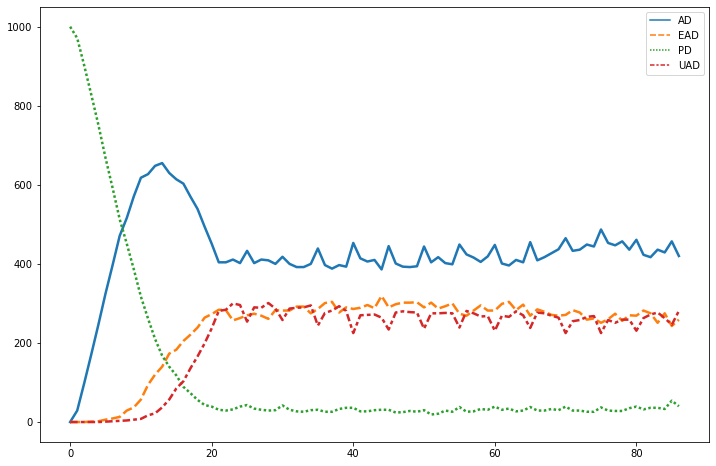

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_club, palette="tab10", linewidth=2.5)
plt.show()

### Which were the days with most drivers getting upgraded or downgraded in the driver engagement cohorts?

In [22]:
_df = df_cohort.groupby(['date', 'change_flag']).agg({'driver_id':'count'}).reset_index()

# Most Upgrades in a day
_df[_df['change_flag'] == 'Upgraded'].sort_values(by='driver_id', ascending=False).head()

,date,change_flag,driver_id
21,2021-08-17,Upgraded,109
41,2021-08-31,Upgraded,105
37,2021-08-27,Upgraded,103
97,2021-09-28,Upgraded,102
167,2021-11-02,Upgraded,102


In [23]:
# Most Downgrades in a day
_df[_df['change_flag'] == 'Downgraded'].sort_values(by='driver_id', ascending=False).head()

,date,change_flag,driver_id
93,2021-09-27,Downgraded,169
135,2021-10-18,Downgraded,167
191,2021-11-15,Downgraded,157
163,2021-11-01,Downgraded,154
219,2021-11-29,Downgraded,149


In [24]:
# Most No Changes in a day
_df[_df['change_flag'] == 'NoChange'].sort_values(by='driver_id', ascending=False).head()

,date,change_flag,driver_id
0,2021-08-03,NoChange,971
68,2021-09-14,NoChange,931
2,2021-08-04,NoChange,930
4,2021-08-05,NoChange,925
6,2021-08-06,NoChange,923


### Drivers with most upgrades or downgrades during the analysis period

In [25]:
_df = df_cohort.groupby(['driver_id', 'change_flag']).agg({'flag': 'count'}).reset_index()

In [26]:
# Most Upgrades by driver
_df[_df['change_flag'] == 'Upgraded'].sort_values(by='flag', ascending=False).head()

,driver_id,change_flag,flag
2414,d08104b6ad15,Upgraded,13
2788,eeed53e7a9af,Upgraded,12
785,43c1e1476447,Upgraded,12
287,1a5aa9a4a2fa,Upgraded,12
2185,ba835a68df25,Upgraded,12


In [27]:
# Most Downgrades by driver
_df[_df['change_flag'] == 'Downgraded'].sort_values(by='flag', ascending=False).head()

,driver_id,change_flag,flag
285,1a5aa9a4a2fa,Downgraded,12
2412,d08104b6ad15,Downgraded,12
168,103f2ddd31f1,Downgraded,10
2415,d0b14cf29cb4,Downgraded,10
447,28b7e2118b63,Downgraded,10


### Drivers who spent most days as `Ultra Active Driver` on consecutive days during the Analysis period

In [28]:
def group_apply(df):
    df = df[df.category == 'UAD']
    df.sort_values(by='date', inplace=True)

    days_list = list()
    last_day = None
    for ri in range(len(df)):
        val = df.iloc[ri]['change_flag']
        if val == 'Upgraded':
            if last_day:
                days = (last_day - first_day).days
                days_list.append(days)
                last_day = None
            else:
                days_list.append(1)
            first_day = df.iloc[ri]['date']

        elif val == 'NoChange':
            last_day = df.iloc[ri]['date']
    
    # at the end of loop
    if last_day:
        days = (last_day - first_day).days
        days_list.append(days)
    else:
        days_list.append(1)

    return max(days_list)

_df = df_cohort.groupby('driver_id').apply(group_apply)
_df.sort_values(ascending=False).head(10)

driver_id
4f29ba60cf48    99
4699212de1d2    95
e1be181e5234    84
3d2732c440c7    82
86de29ae0a99    81
983b614e1a96    74
c356f7b8d4f5    72
3017ecd0079f    70
3fc54bdbf896    70
21c373ed732f    65
dtype: int64

### Drivers who spent most days as `Passive Driver` overall during the Analysis period

In [29]:
# Of the total - 122 days
_df = df_cohort.groupby(['driver_id', 'category']).agg({'flag':'count'}).reset_index()
_df = _df[_df['category'] == 'PD']
_df.sort_values(by='flag', ascending=False).head(10)

,driver_id,category,flag
1077,46f901a045b0,PD,53
2653,b11cf9da722c,PD,42
3539,eb1b72b9856c,PD,40
2395,a1b00c211717,PD,40
1490,63530e963b0d,PD,38
1725,769d0ed227ae,PD,36
2626,af9d6a81aeaa,PD,36
2590,aea53ec74820,PD,35
119,08ba198865d6,PD,35
1493,63acfadae72e,PD,35


### Average number of trips, time_spent or distance by `Ultra Active Drivers`

In [30]:
# time in minutes, distance in km
_df = df_cohort[(df_cohort['category'] == 'UAD')]
drivers = _df.driver_id.tolist()
_df = df_delivery[df_delivery['driver_id'].isin(drivers)]
_df = _df[_df['trips'] != 0]
_df[['trips', 'time_spent', 'distance']].mean()

trips         1.518745
time_spent    8.607248
distance      5.020904
dtype: float64

### Top drivers with most number of trips, time_spent or distance under `Ultra Active Drivers` category

In [31]:
# time in minutes, distance in km
_df = _df.groupby('driver_id').agg({'trips': 'sum', 'time_spent': 'sum', 'distance': 'sum'}).reset_index()
_df.sort_values(by='trips', ascending=False).head(5)


,driver_id,trips,time_spent,distance
676,c356f7b8d4f5,66.0,379.172,221.20
277,4f29ba60cf48,64.0,386.632,225.54
246,4699212de1d2,62.0,372.145,217.09
675,c2dd1bf17660,61.0,366.242,213.68
779,e1be181e5234,61.0,356.537,207.99


In [32]:
_df.sort_values(by='time_spent', ascending=False).head(5)

,driver_id,trips,time_spent,distance
277,4f29ba60cf48,64.0,386.632,225.54
676,c356f7b8d4f5,66.0,379.172,221.20
246,4699212de1d2,62.0,372.145,217.09
675,c2dd1bf17660,61.0,366.242,213.68
215,3d2732c440c7,60.0,363.194,211.87


In [33]:
_df.sort_values(by='distance', ascending=False).head(5)

,driver_id,trips,time_spent,distance
277,4f29ba60cf48,64.0,386.632,225.54
676,c356f7b8d4f5,66.0,379.172,221.20
246,4699212de1d2,62.0,372.145,217.09
675,c2dd1bf17660,61.0,366.242,213.68
215,3d2732c440c7,60.0,363.194,211.87
